# Table access patterns

We want to see if we can speed up memory access times by reordering table dimensions (and possibly reordering the templates, too).

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('dark_background')

In [10]:
import cPickle as pickle
from os import *
from os.path import *

from plotGoodies import removeBorder

In [11]:
outdir = 'table_access_pattern'
makedirs(outdir)

Retrieve the indices stored during a "debug" run (where lists were provided to populate with these, and which were stored after running).

Note that I used only ckv emitters (point_ckv cascade + muon track) so there are no "omni" lookups and hence each indexing operation used the same number of indices (5 for table lookups, and 4 for time-independent lookups).

In [5]:
table_indices = np.array(pickle.load(open('/data/justin/retro/recos/2018-04-06.speeddbg/evt1-table_indices.pkl', 'rb')))
t_indep_indices = np.array(pickle.load(open('/data/justin/retro/recos/2018-04-06.speeddbg/evt1-t_indep_table_indices.pkl', 'rb')))

In [63]:
rbe = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_0/r_bin_edges.npy')
ctbe = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_0/costheta_bin_edges.npy')
tbe = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_0/t_bin_edges.npy')
ctdbe = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_0/costhetadir_bin_edges.npy')
dpdbe = np.load('/data/icecube/retro_tables/large_5d_notilt_combined/large_5d_notilt_string_dc_depth_0/deltaphidir_bin_edges.npy')
n_rb = len(rbe) - 1
n_ctb = len(ctbe) - 1
n_tb = len(tbe) - 1
n_ctdb = len(ctbe) - 1
n_dpdb = len(dpdbe) - 1
print ('n_rbins = {}, n_costhetabins = {}, n_tbins = {}, n_costhetadirbins = {}, n_deltaphidirbins = {}'
       .format(n_rb, n_ctb, n_tb, n_ctb, n_dpdb))

n_rbins = 100, n_costhetabins = 40, n_tbins = 250, n_costhetadirbins = 40, n_deltaphidirbins = 40


## Access pattern for template map tables

Here we look at the access pattern for _which_ directional template to load.
I.e., this should inform us how we should order the `ckv_template_map.npy` tables (or the stacked version of these, `stacked_ckv_template_map.npy`).

Notes:
* Since the directional template chosen is in $\cos\theta_{\rm dir}, \Delta\phi_{\rm dir}$, for this part we just look at the first three dimensions that index _into_ those maps: $r$, $\cos\theta$, and $t$.
* I normalize each index to the number of bins in that dimension

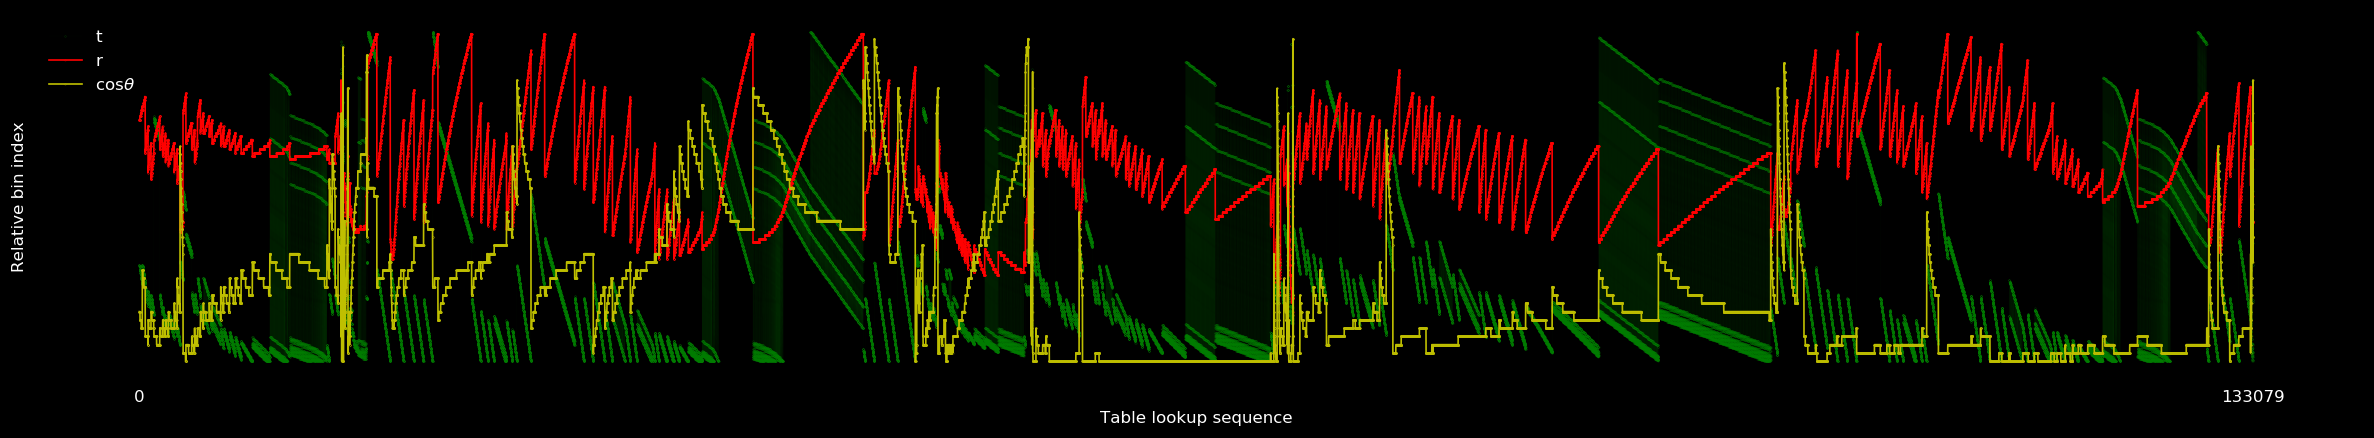

In [12]:
fig, ax = plt.subplots(figsize=(25, 4), dpi=120)
ax.plot(table_indices[:, 2]/n_tb, 'g.-', ms=0.2, lw=0.01, label='t')
ax.plot(table_indices[:, 0]/n_rb, 'r.-', ms=0.2, lw=1, label='r')
ax.plot(table_indices[:, 1]/n_ctb, 'y.-', ms=0.2, lw=1, label=r'$\cos\theta$')
ax.legend(loc='best', frameon=False)
removeBorder(ax, left=False, bottom=False)
ax.set_xticks([0, table_indices.shape[0]])
ax.set_yticks([])
ax.set_ylabel('Relative bin index')
ax.set_xlabel('Table lookup sequence')

fbase = join(outdir, 'table_map_lookup_pattern')
fig.savefig(fbase + '.png', dpi=200)
fig.savefig(fbase + '.pdf')
pass

It is clear that time dimension has the most "jumpy" access pattern, and $\cos\theta$ has stretches of no change at all.

Therefore, we should (using row-major-ordering... i.e., C-convention or the numpy default), we should order the template map dimensions as $(\cos\theta, r, t)$.

As a check, let's look at the frequency components of the access patterns (with means subtracted off).

In [47]:
%%time
tbl_fft = np.fft.fft((table_indices[:, :3] - np.mean(table_indices[:, :3], axis=0)) / np.array([100, 40, 250])[np.newaxis, :], axis=0)
mag_tbl_fft = np.abs(tbl_fft)

CPU times: user 86.6 ms, sys: 19.9 ms, total: 107 ms
Wall time: 105 ms


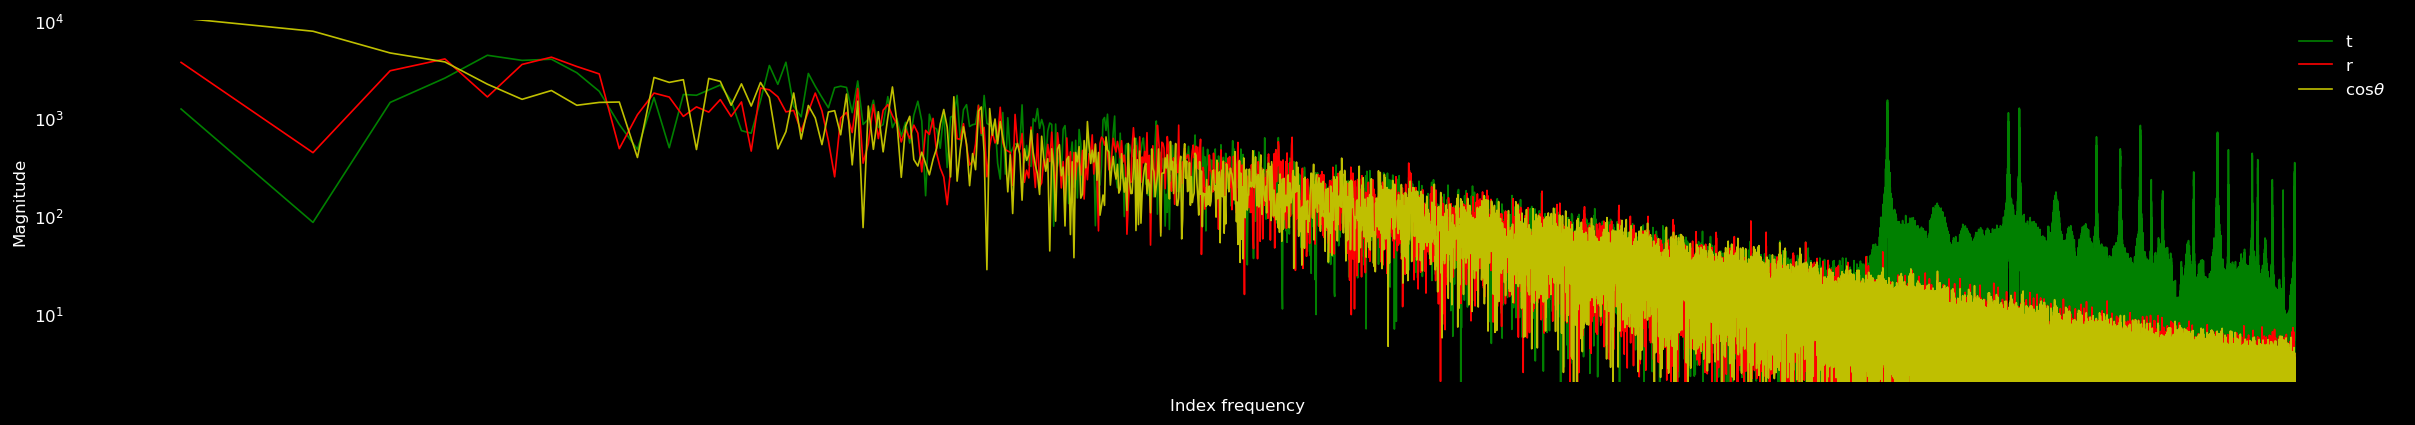

In [62]:
num = tbl_fft.shape[0]
freq = np.fft.fftfreq(num)
nk = int(np.ceil(num / 2)) if (num % 2 == 1) else int(np.floor(num / 2))

fig, ax = plt.subplots(figsize=(25, 4), dpi=120)
ax.plot(freq[1:nk], mag_tbl_fft[1:nk, 2], 'g-', lw=1, label='t')
ax.plot(freq[1:nk], mag_tbl_fft[1:nk, 0], 'r-', lw=1, label='r')
ax.plot(freq[1:nk], mag_tbl_fft[1:nk, 1], 'y-', lw=1, label=r'$\cos\theta$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2, 1e4])
# ax.plot(mag_tbl_fft[:, 0], 'r.-', ms=0.2, lw=1, label='r')
# ax.plot(mag_tbl_fft[:, 1], 'y.-', ms=0.2, lw=1, label=r'$\cos\theta$')
ax.legend(loc='best', frameon=False)
removeBorder(ax, left=False, bottom=False)
ax.set_xticks([])
# ax.set_yticks([])
ax.set_ylabel('Magnitude')
ax.set_xlabel('Index frequency')

fbase = join(outdir, 'table_map_lookup_pattern_freqdomain')
fig.savefig(fbase + '.png', dpi=200)
pass

* It's clear that $t$ has the highest-frequency compoentns and therefore should be the last dimension (as it is already)
* While $r$ and $\cos\theta$ are hard to distinguish at the high frequencies, the stretches of little to no change in $\cos\theta$ show up at the low frequency range, which again supports putting that dimension first.

## Template usage frequency

Now that we've addressed the _lookup_ table for looking up templates, let's look at how often we use the templates.
Reordering the templates in order of frequency of their usage can provide further speedups when accessing these (particularly because a good number can fit into L3 cache).

A template is uniquely identified by the combination of the first three indices in the table (what I examined above), so putting these into tuples and counting the unique tuples will provide the information necessary.

In [69]:
tmpl_ids = table_indices[:, :3]

In [72]:
unique_templ_ids, indices, inverse, counts = np.unique(tmpl_ids, axis=0, return_index=True, return_inverse=True, return_counts=True)

In [77]:
descending_order_counts_indices = np.argsort(counts)[::-1]

In [78]:
counts[descending_order_counts_indices]

array([110,  98,  97, ...,   1,   1,   1])

In [81]:
unique_templ_ids[descending_order_counts_indices, ...][:20]

array([[63, 11,  3],
       [62, 12,  6],
       [62, 12,  5],
       [62, 12,  7],
       [63, 11,  2],
       [64, 10,  0],
       [64, 10,  5],
       [63, 11,  9],
       [63, 11,  1],
       [63, 11,  4],
       [63, 11,  8],
       [64, 10,  6],
       [62, 12,  8],
       [64, 10, 10],
       [65,  9,  6],
       [63, 11, 10],
       [63, 11, 13],
       [64, 10,  4],
       [62, 12,  4],
       [64, 10,  1]])

In [82]:
len(unique_templ_ids)

15266

Okay, so for now I realize I should probably wait to get more data on template access frequency.
Above, I'm only using info from a single event, which will much more strongly bias which templates were accessed (as compared to the template map & time-independent table lookup patterns, which I expect are somewhat uniform across events).

## Time-independent table access pattern

These tables are accessed all at once (no pointers to templates as above), so we consider _all_ dimensions in the time-independent tables simultaneously as candidates for reordering.

CPU times: user 22.2 s, sys: 1.06 s, total: 23.3 s
Wall time: 23.4 s


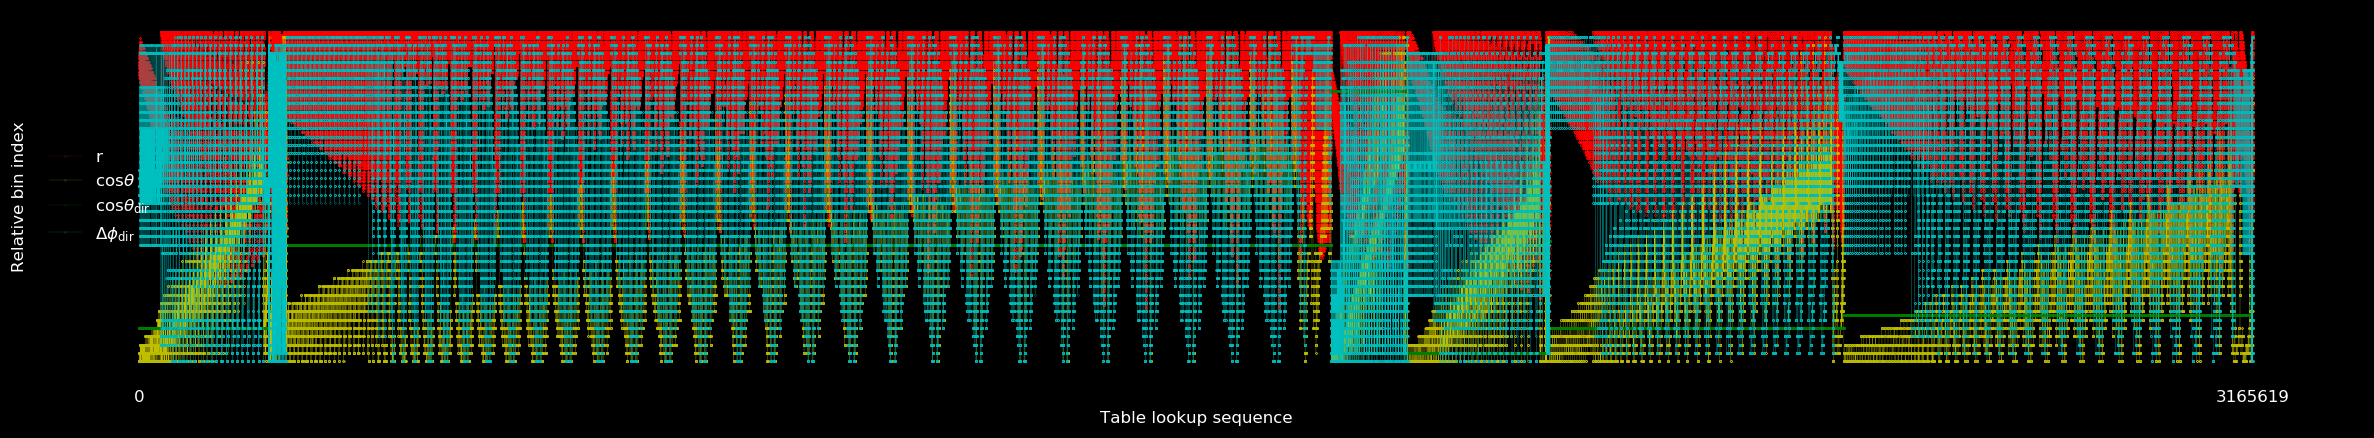

In [13]:
%%time

fig, ax = plt.subplots(figsize=(25, 4), dpi=120)
ax.plot(t_indep_indices[:, 0]/100, 'r.-', ms=0.2, lw=0.1, label='r')
ax.plot(t_indep_indices[:, 1]/40, 'y.-', ms=0.2, lw=0.1, label=r'$\cos\theta$')
ax.plot(t_indep_indices[:, 2]/80, 'g.-', ms=0.2, lw=0.1, label=r'$\cos\theta_{\rm dir}$')
ax.plot(t_indep_indices[:, 3]/40, 'c.-', ms=0.2, lw=0.1, label=r'$\Delta\phi_{\rm dir}$')
ax.legend(loc='best', frameon=False)
removeBorder(ax, left=False, bottom=False)
ax.set_xticks([0, t_indep_indices.shape[0]])
ax.set_yticks([])
ax.set_ylabel('Relative bin index')
ax.set_xlabel('Table lookup sequence')

fbase = join(outdir, 't_indep_table_lookup_pattern')
fig.savefig(fbase + '.png', dpi=300)
#fig.savefig(fbase + '.pdf')
pass

In [51]:
%%time
t_indep_fft = np.fft.fft((t_indep_indices - np.mean(t_indep_indices, axis=0)) / np.array([100, 40, 80, 40])[np.newaxis, :], axis=0)
mag_t_indp_fft = np.abs(t_indep_fft)

CPU times: user 1.92 s, sys: 388 ms, total: 2.31 s
Wall time: 2.31 s


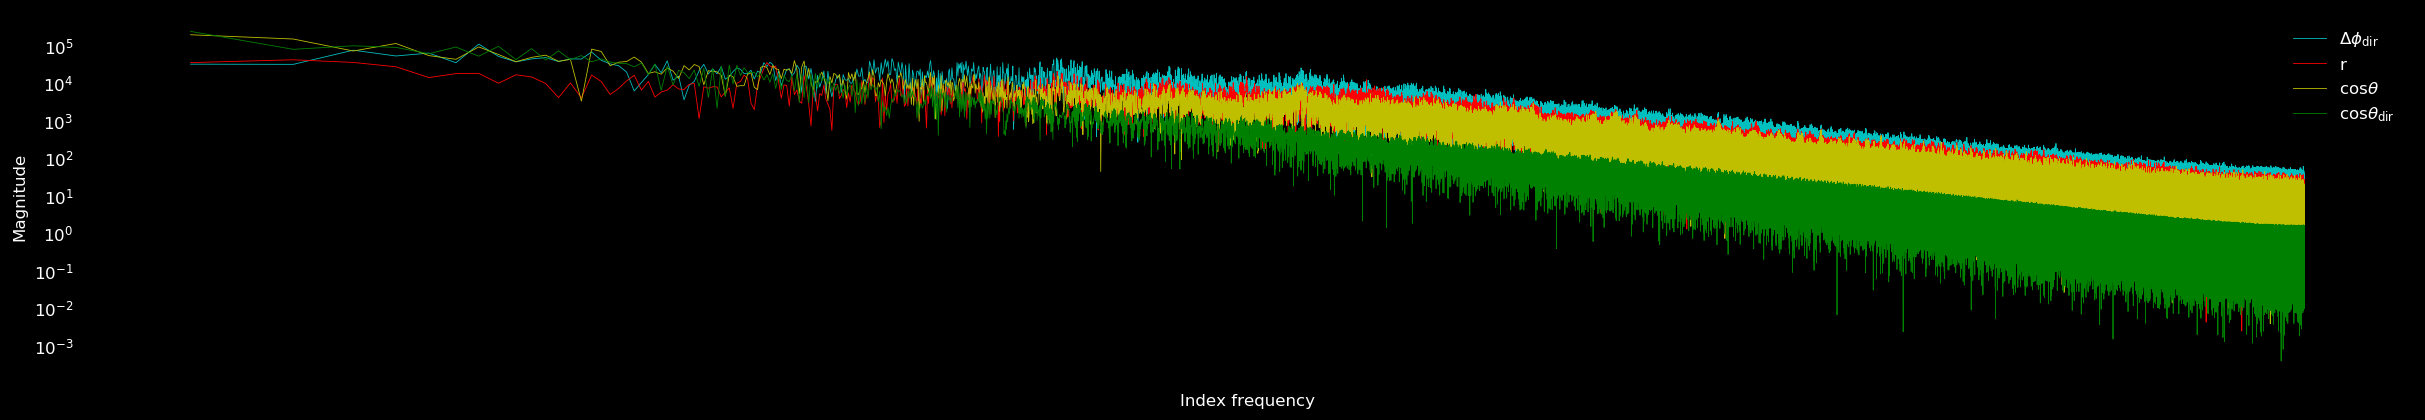

In [60]:
num = mag_t_indp_fft.shape[0]
freq = np.fft.fftfreq(num)
nk = int(np.ceil(num / 2)) if (num % 2 == 1) else int(np.floor(num / 2))
si = 1 #int(nk*98/100)
fig, ax = plt.subplots(figsize=(25, 4), dpi=120)
ax.plot(freq[si:nk], mag_t_indp_fft[si:nk, 3], 'c-', ms=0.2, lw=0.5, label=r'$\Delta\phi_{\rm dir}$')
ax.plot(freq[si:nk], mag_t_indp_fft[si:nk, 0], 'r-', ms=0.2, lw=0.5, label='r')
ax.plot(freq[si:nk], mag_t_indp_fft[si:nk, 1], 'y-', ms=0.2, lw=0.5, label=r'$\cos\theta$')
ax.plot(freq[si:nk], mag_t_indp_fft[si:nk, 2], 'g-', ms=0.2, lw=0.5, label=r'$\cos\theta_{\rm dir}$')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([2, 1e4])
# ax.plot(mag_tbl_fft[:, 0], 'r.-', ms=0.2, lw=1, label='r')
# ax.plot(mag_tbl_fft[:, 1], 'y.-', ms=0.2, lw=1, label=r'$\cos\theta$')
ax.legend(loc='best', frameon=False)
removeBorder(ax, left=False, bottom=False)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_ylabel('Magnitude')
ax.set_xlabel('Index frequency')

fbase = join(outdir, 't_indep_table_lookup_pattern_freqdomain')
fig.savefig(fbase + '.png', dpi=200)
#fig.savefig(fbase + '.pdf')
pass